# NYC ACCIDENT RISK PREDICTOR


In [ ]:
# CELL 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")
print("You can now access files from: /content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
You can now access files from: /content/drive/MyDrive/


In [ ]:
# CELL 2: Install Required Libraries
!pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn joblib -q

print("All libraries installed!")

All libraries installed!


In [ ]:
# CELL 3: Import All Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, precision_recall_fscore_support
)
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported!")

All libraries imported!


In [ ]:
# CELL 4: Load Data from Colab
import os

# Option 1: If file is already uploaded in Colab session
#filename = 'Motor_Vehicle_Collisions_-_Crashes.csv'

# Option 2: If file is in sample_data folder
# filename = 'sample_data/Motor_Vehicle_Collisions_-_Crashes.csv'

# Option 3: If file is in Google Drive
 # Aligned all the way to the left
filename = '/content/drive/MyDrive/NYC_Data/Motor_Vehicle_Collisions_-_Crashes.csv'

if os.path.exists(filename):
    print(f"File found: {filename}")
    print(f"File size: {os.path.getsize(filename) / (1024**2):.2f} MB")
else:
    print(f"Error: File not found at {filename}")
    print("\nAvailable files in current directory:")
    for f in os.listdir('.'):
        if f.endswith('.csv'):
            print(f"  - {f}")

File found: /content/drive/MyDrive/NYC_Data/Motor_Vehicle_Collisions_-_Crashes.csv
File size: 401.22 MB


In [ ]:
# CELL 5: Load and Initial Exploration
print("=" * 70)
print("STEP 1: DATA LOADING AND INITIAL EXPLORATION")
print("=" * 70)

df = pd.read_csv(filename)
print(f"\nLoaded {len(df):,} records")
print(f"Columns: {df.shape[1]}")

print("\nAvailable Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

contrib_cols = [col for col in df.columns if 'CONTRIBUTING FACTOR' in col.upper()]
print(f"\nFound {len(contrib_cols)} CONTRIBUTING FACTOR columns:")
for col in contrib_cols:
    print(f"   - {col}")

print(f"\nMissing Values:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
for col, count in missing.head(10).items():
    pct = (count / len(df)) * 100
    print(f"   {col[:40]:40s}: {count:,} ({pct:.1f}%)")

STEP 1: DATA LOADING AND INITIAL EXPLORATION

Loaded 1,972,121 records
Columns: 29

Available Columns:
    1. CRASH DATE
    2. CRASH TIME
    3. BOROUGH
    4. ZIP CODE
    5. LATITUDE
    6. LONGITUDE
    7. LOCATION
    8. ON STREET NAME
    9. CROSS STREET NAME
   10. OFF STREET NAME
   11. NUMBER OF PERSONS INJURED
   12. NUMBER OF PERSONS KILLED
   13. NUMBER OF PEDESTRIANS INJURED
   14. NUMBER OF PEDESTRIANS KILLED
   15. NUMBER OF CYCLIST INJURED
   16. NUMBER OF CYCLIST KILLED
   17. NUMBER OF MOTORIST INJURED
   18. NUMBER OF MOTORIST KILLED
   19. CONTRIBUTING FACTOR VEHICLE 1
   20. CONTRIBUTING FACTOR VEHICLE 2
   21. CONTRIBUTING FACTOR VEHICLE 3
   22. CONTRIBUTING FACTOR VEHICLE 4
   23. CONTRIBUTING FACTOR VEHICLE 5
   24. COLLISION_ID
   25. VEHICLE TYPE CODE 1
   26. VEHICLE TYPE CODE 2
   27. VEHICLE TYPE CODE 3
   28. VEHICLE TYPE CODE 4
   29. VEHICLE TYPE CODE 5

Found 5 CONTRIBUTING FACTOR columns:
   - CONTRIBUTING FACTOR VEHICLE 1
   - CONTRIBUTING FACTOR VEH

In [ ]:
# CELL 6: Data Cleaning (IMPROVED - เก็บข้อมูลมากขึ้น)
print("\n" + "=" * 70)
print("STEP 2: DATA CLEANING")
print("=" * 70)

original_len = len(df)

print("\nCleaning data...")
df = df.dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE', 'CRASH TIME'])
print(f"   Removed {original_len - len(df):,} rows with missing coordinates/time")

df['DATETIME'] = pd.to_datetime(
    df['CRASH DATE'] + ' ' + df['CRASH TIME'],
    errors='coerce'
)
df = df.dropna(subset=['DATETIME'])

# แทนที่จะลบ "Unspecified" ให้เก็บไว้ และ encode เป็น category
print("\nHandling 'Unspecified' values...")
print("   Keeping 'Unspecified' as a valid category (not removing)")

# Fill missing BOROUGH with 'Unknown'
df['BOROUGH'] = df['BOROUGH'].fillna('Unknown')

print(f"\nFinal dataset: {len(df):,} records ({len(df)/original_len*100:.1f}% retained)")


STEP 2: DATA CLEANING

Cleaning data...
   Removed 226,028 rows with missing coordinates/time

Handling 'Unspecified' values...
   Keeping 'Unspecified' as a valid category (not removing)

Final dataset: 1,746,093 records (88.5% retained)


In [ ]:
# CELL 7: Feature Engineering
print("\n" + "=" * 70)
print("STEP 3: FEATURE ENGINEERING")
print("=" * 70)

df['hour'] = df['DATETIME'].dt.hour
df['day'] = df['DATETIME'].dt.day
df['month'] = df['DATETIME'].dt.month
df['day_of_week'] = df['DATETIME'].dt.dayofweek
df['is_weekend'] = (df['DATETIME'].dt.dayofweek >= 5).astype(int)
df['is_rush_hour'] = (
    df['hour'].between(6, 8) | df['hour'].between(16, 19)
).astype(int)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

print("Time features created:")
print("   - hour, day, month, day_of_week")
print("   - is_weekend, is_rush_hour")
print("   - Cyclical encoding (sin/cos)")


STEP 3: FEATURE ENGINEERING
Time features created:
   - hour, day, month, day_of_week
   - is_weekend, is_rush_hour
   - Cyclical encoding (sin/cos)


In [ ]:
# CELL 8: Handle CONTRIBUTING FACTOR (IMPROVED)
print("\n" + "=" * 70)
print("STEP 4: ANALYZING CONTRIBUTING FACTOR VEHICLE")
print("=" * 70)

contrib_cols = [col for col in df.columns if 'CONTRIBUTING FACTOR VEHICLE' in col]

if len(contrib_cols) > 0:
    print(f"\nAnalyzing {len(contrib_cols)} CONTRIBUTING FACTOR columns...")

    if 'CONTRIBUTING FACTOR VEHICLE 1' in df.columns:
        main_contrib_col = 'CONTRIBUTING FACTOR VEHICLE 1'

        # Keep Unspecified, treat as valid category
        df[main_contrib_col] = df[main_contrib_col].fillna('Unknown')

        # Encode
        le_contrib = LabelEncoder()
        df['contrib_factor_encoded'] = le_contrib.fit_transform(df[main_contrib_col])

        print(f"\n   Using: {main_contrib_col}")
        print(f"   Encoded into 'contrib_factor_encoded'")
        print(f"   Unique values: {df['contrib_factor_encoded'].nunique()}")

# Add BOROUGH encoding
if 'BOROUGH' in df.columns:
    le_borough = LabelEncoder()
    df['borough_encoded'] = le_borough.fit_transform(df['BOROUGH'])
    print(f"\n   Added: BOROUGH encoding")
    print(f"   Unique values: {df['borough_encoded'].nunique()}")
else:
    df['borough_encoded'] = 0


STEP 4: ANALYZING CONTRIBUTING FACTOR VEHICLE

Analyzing 5 CONTRIBUTING FACTOR columns...

   Using: CONTRIBUTING FACTOR VEHICLE 1
   Encoded into 'contrib_factor_encoded'
   Unique values: 62

   Added: BOROUGH encoding
   Unique values: 6


In [ ]:
# CELL 9: Create Risk Labels
print("\n" + "=" * 70)
print("STEP 5: CREATING RISK LABELS")
print("=" * 70)

df['risk_score'] = (
    df['NUMBER OF PERSONS INJURED'].fillna(0) +
    2 * df['NUMBER OF PERSONS KILLED'].fillna(0)
)

# Use quantile-based labeling for better balance
quantiles = df[df['risk_score'] > 0]['risk_score'].quantile([0.5, 0.9])

def label_risk(x):
    if x == 0:
        return 0  # Low Risk - No injuries
    elif x <= quantiles[0.5]:  # Bottom 50%
        return 1  # Medium Risk
    else:  # Top 50%
        return 2  # High Risk

df['risk_level'] = df['risk_score'].apply(label_risk)

print("Risk Labeling (QUANTILE-BASED):")
print("   - Low Risk (0): No injuries")
print(f"   - Medium Risk (1): 1-{quantiles[0.5]:.0f} injuries")
print(f"   - High Risk (2): {quantiles[0.5]:.0f}+ injuries")

print("\nClass Distribution:")
class_counts = df['risk_level'].value_counts().sort_index()
for label, count in class_counts.items():
    pct = (count / len(df)) * 100
    print(f"   Class {label}: {count:,} ({pct:.1f}%)")

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.1f}:1")


STEP 5: CREATING RISK LABELS
Risk Labeling (QUANTILE-BASED):
   - Low Risk (0): No injuries
   - Medium Risk (1): 1-1 injuries
   - High Risk (2): 1+ injuries

Class Distribution:
   Class 0: 1,359,268 (77.8%)
   Class 1: 300,352 (17.2%)
   Class 2: 86,473 (5.0%)

Imbalance Ratio: 15.7:1


In [ ]:
# CELL 10: Sample Data (OPTIMIZED FOR COLAB RAM)
print("\n" + "=" * 70)
print("STEP 6: DATA SAMPLING (OPTIMIZED FOR RAM)")
print("=" * 70)

SAMPLE_SIZE = 400000

if len(df) > SAMPLE_SIZE:
    print(f"Dataset too large ({len(df):,} records)")
    print(f"   Sampling {SAMPLE_SIZE:,} records for Colab RAM limit...")

    # Stratified sampling
    df_sampled = df.groupby('risk_level', group_keys=False).apply(
        lambda x: x.sample(
            n=min(len(x), int(SAMPLE_SIZE * len(x) / len(df))),
            random_state=42
        )
    )

    print(f"   Sampled to {len(df_sampled):,} records")
    print(f"\n   Class distribution after sampling:")
    for label, count in df_sampled['risk_level'].value_counts().sort_index().items():
        pct = (count / len(df_sampled)) * 100
        print(f"      Class {label}: {count:,} ({pct:.1f}%)")

    # Free memory
    del df
    import gc
    gc.collect()

    df = df_sampled
    del df_sampled
    gc.collect()

    print(f"\n   Memory cleared")
else:
    print(f"Dataset size OK ({len(df):,} records)")


STEP 6: DATA SAMPLING (OPTIMIZED FOR RAM)
Dataset too large (1,746,093 records)
   Sampling 400,000 records for Colab RAM limit...
   Sampled to 399,999 records

   Class distribution after sampling:
      Class 0: 311,385 (77.8%)
      Class 1: 68,805 (17.2%)
      Class 2: 19,809 (5.0%)

   Memory cleared



STEP 7: CORRELATION ANALYSIS


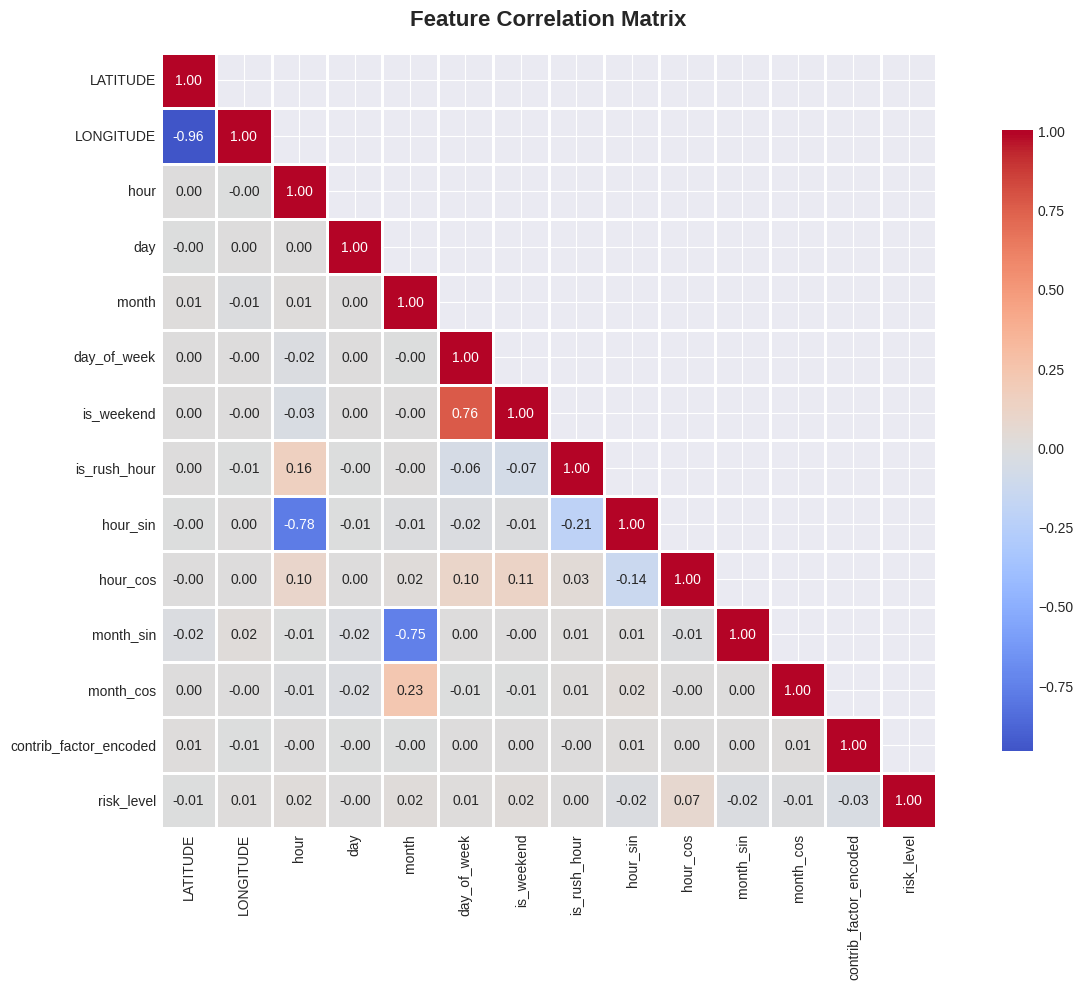


Correlation with Risk Level:
risk_level                1.000000
hour_cos                  0.070655
hour                      0.021215
is_weekend                0.018946
month                     0.016795
day_of_week               0.013210
LONGITUDE                 0.009156
is_rush_hour              0.003929
day                      -0.001234
LATITUDE                 -0.008187
month_cos                -0.010614
hour_sin                 -0.021972
month_sin                -0.022426
contrib_factor_encoded   -0.034589
Name: risk_level, dtype: float64

Highly Correlated Feature Pairs (|r| > 0.8):
   LATITUDE <-> LONGITUDE: -0.957


In [ ]:
# CELL 11: Correlation Analysis
print("\n" + "=" * 70)
print("STEP 7: CORRELATION ANALYSIS")
print("=" * 70)

numeric_features = [
    'LATITUDE', 'LONGITUDE', 'hour', 'day', 'month', 'day_of_week',
    'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos',
    'month_sin', 'month_cos', 'contrib_factor_encoded', 'risk_level'
]

numeric_features = [col for col in numeric_features if col in df.columns]

corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix), k=1)
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

target_corr = corr_matrix['risk_level'].sort_values(ascending=False)
print("\nCorrelation with Risk Level:")
print(target_corr)

print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"   {feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("   No highly correlated pairs found")


STEP 8: FEATURE SELECTION
Features: 10 (with interactions)
   ['LATITUDE', 'LONGITUDE', 'lat_long_interaction', 'hour', 'hour_weekend', 'day_of_week', 'is_weekend', 'is_rush_hour', 'rush_hour_weekday', 'contrib_factor_encoded']

Calculating feature importance...

   Feature Importance:
      contrib_factor_encoded        : 0.2226
      LATITUDE                      : 0.1900
      lat_long_interaction          : 0.1878
      LONGITUDE                     : 0.1871
      hour                          : 0.0987
      day_of_week                   : 0.0497
      hour_weekend                  : 0.0367
      is_rush_hour                  : 0.0115
      rush_hour_weekday             : 0.0087
      is_weekend                    : 0.0072


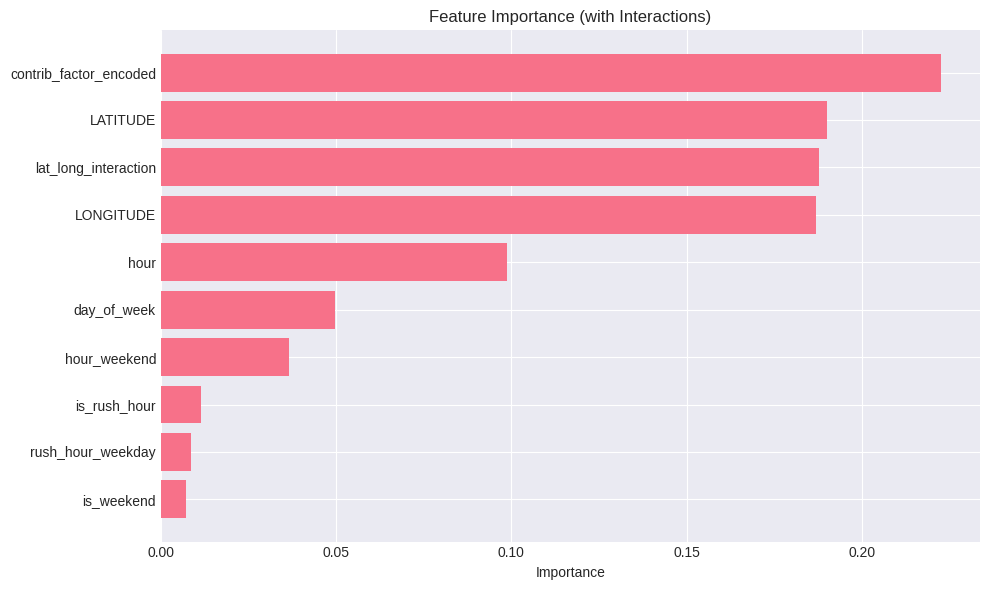


Using 10 features


In [ ]:
# CELL 12: Feature Selection
print("\n" + "=" * 70)
print("STEP 8: FEATURE SELECTION")
print("=" * 70)

# Add interaction features
df['lat_long_interaction'] = df['LATITUDE'] * df['LONGITUDE']
df['hour_weekend'] = df['hour'] * df['is_weekend']
df['rush_hour_weekday'] = df['is_rush_hour'] * (1 - df['is_weekend'])

feature_cols = [
    'LATITUDE',
    'LONGITUDE',
    'lat_long_interaction',  # NEW
    'hour',
    'hour_weekend',  # NEW
    'day_of_week',
    'is_weekend',
    'is_rush_hour',
    'rush_hour_weekday',  # NEW
    'contrib_factor_encoded'
]

feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].astype(float)
y = df['risk_level']

print(f"Features: {len(feature_cols)} (with interactions)")
print(f"   {feature_cols}")

# Calculate feature importance
print("\nCalculating feature importance...")
sample_size = min(50000, len(X))
sample_indices = X.sample(sample_size, random_state=42).index
X_sample = X.loc[sample_indices]
y_sample = y.loc[sample_indices]

rf_selector = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=2
)
rf_selector.fit(X_sample, y_sample)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("\n   Feature Importance:")
for idx, row in feature_importance.iterrows():
    print(f"      {row['feature']:30s}: {row['importance']:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (with Interactions)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

del rf_selector, X_sample, y_sample
import gc
gc.collect()

selected_features = feature_cols
print(f"\nUsing {len(selected_features)} features")

In [ ]:
# CELL 13: Train/Test Split
print("\n" + "=" * 70)
print("STEP 9: TRAIN/TEST SPLIT")
print("=" * 70)

X_selected = df[selected_features].astype(float)
y = df['risk_level']

print(f"Using {len(selected_features)} selected features")

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

print(f"\nData Split:")
print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set:     {len(X_test):,} samples")
print(f"   Split ratio:  {len(X_train)/len(X_selected)*100:.1f}% / {len(X_test)/len(X_selected)*100:.1f}%")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures standardized (mean=0, std=1)")


STEP 9: TRAIN/TEST SPLIT
Using 10 selected features

Data Split:
   Training set: 339,999 samples
   Test set:     60,000 samples
   Split ratio:  85.0% / 15.0%

Features standardized (mean=0, std=1)


In [ ]:
# CELL 14: SMOTE + Undersampling (RAM OPTIMIZED)
print("\n" + "=" * 70)
print("STEP 10: HANDLING IMBALANCED DATA")
print("=" * 70)

print("Before Resampling:")
class_counts_train = y_train.value_counts().sort_index()
for label, count in class_counts_train.items():
    print(f"   Class {label}: {count:,}")

print("\nApplying SMOTE (controlled sampling)...")

max_count = class_counts_train.max()
max_class = class_counts_train.idxmax()

sampling_strategy = {}
for class_label, count in class_counts_train.items():
    if class_label != max_class:
        if class_label == 1:
            target = max(count, int(max_count * 0.7))
        elif class_label == 2:
            target = max(count, int(max_count * 0.5))
        else:
            target = max(count, int(max_count * 0.6))

        if target > count:
            sampling_strategy[class_label] = target

print(f"SMOTE Strategy: {sampling_strategy}")

if sampling_strategy:
    smote = SMOTE(
        sampling_strategy=sampling_strategy,
        k_neighbors=min(5, min(class_counts_train) - 1),
        random_state=42
    )
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    print("   After SMOTE:")
    for label, count in pd.Series(y_train_smote).value_counts().sort_index().items():
        print(f"      Class {label}: {count:,}")


    import gc
    gc.collect()
else:
    X_train_smote = X_train_scaled
    y_train_smote = y_train

# Lighter undersampling
smote_counts = pd.Series(y_train_smote).value_counts()
max_after_smote = smote_counts.max()
max_class_after_smote = smote_counts.idxmax()
target_for_max = int(smote_counts[smote_counts.index != max_class_after_smote].mean() * 1.3)

rus = RandomUnderSampler(
    sampling_strategy={max_class_after_smote: target_for_max},
    random_state=42
)

X_train_balanced, y_train_balanced = rus.fit_resample(X_train_smote, y_train_smote)

print("\n   After Undersampling:")
for label, count in pd.Series(y_train_balanced).value_counts().sort_index().items():
    print(f"      Class {label}: {count:,}")

new_counts = pd.Series(y_train_balanced).value_counts()
new_imbalance = new_counts.max() / new_counts.min()
print(f"\n   New Imbalance Ratio: {new_imbalance:.2f}:1 (was {imbalance_ratio:.1f}:1)")

# Clear memory
del X_train_smote, y_train_smote
import gc
gc.collect()
print("\n   Memory cleared")


STEP 10: HANDLING IMBALANCED DATA
Before Resampling:
   Class 0: 264,677
   Class 1: 58,484
   Class 2: 16,838

Applying SMOTE (controlled sampling)...
SMOTE Strategy: {1: 185273, 2: 132338}
   After SMOTE:
      Class 0: 264,677
      Class 1: 185,273
      Class 2: 132,338

   After Undersampling:
      Class 0: 206,447
      Class 1: 185,273
      Class 2: 132,338

   New Imbalance Ratio: 1.56:1 (was 15.7:1)

   Memory cleared


In [ ]:
# CELL 15: Train Model
print("\n" + "=" * 70)
print("STEP 11: TRAINING MODEL (XGBOOST)")
print("=" * 70)

# Install XGBoost
!pip install xgboost -q

import xgboost as xgb
import gc

models = {}

print("\nTraining XGBoost (optimized for imbalanced data)...")

# Calculate scale_pos_weight for each class
class_counts = pd.Series(y_train_balanced).value_counts()
scale_pos_weight = class_counts[0] / class_counts.min()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=2,
    verbosity=1
)

xgb_model.fit(X_train_balanced, y_train_balanced)
models['xgboost'] = xgb_model

del X_train_balanced, y_train_balanced
gc.collect()

print(f"\nXGBoost trained successfully!")
print(f"Memory cleared")


STEP 11: TRAINING MODEL (XGBOOST)

Training XGBoost (optimized for imbalanced data)...

XGBoost trained successfully!
Memory cleared


In [ ]:
# CELL 16: Evaluate Model
print("\n" + "=" * 70)
print("STEP 12: MODEL EVALUATION")
print("=" * 70)

results = {}

# Get the first (and only) model from dictionary
model_name = list(models.keys())[0]
model = models[model_name]

y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)

results[model_name] = {
    'accuracy': acc,
    'f1_weighted': f1_weighted,
    'f1_macro': f1_macro,
    'confusion_matrix': cm,
    'y_pred': y_pred
}

print(f"\nMODEL: {model_name.upper()}")
print(f"=" * 50)
print(f"Accuracy:      {acc:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")
print(f"F1 (macro):    {f1_macro:.4f}")

print(f"\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=['Low', 'Medium', 'High'],
    zero_division=0
))


STEP 12: MODEL EVALUATION

MODEL: XGBOOST
Accuracy:      0.6280
F1 (weighted): 0.6551
F1 (macro):    0.3993

Classification Report:
              precision    recall  f1-score   support

         Low       0.83      0.71      0.77     46708
      Medium       0.26      0.37      0.31     10321
        High       0.10      0.17      0.13      2971

    accuracy                           0.63     60000
   macro avg       0.40      0.42      0.40     60000
weighted avg       0.69      0.63      0.66     60000



In [ ]:
# CELL 17: Model Results
print("\n" + "=" * 70)
print("STEP 13: MODEL RESULTS")
print("=" * 70)

model_name = list(results.keys())[0]
best_f1 = results[model_name]['f1_weighted']

print(f"\nMODEL: {model_name.upper()}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Accuracy: {results[model_name]['accuracy']:.4f}")
print(f"   Status: {'PASSED' if best_f1 >= 0.70 else 'BELOW TARGET'} (target >= 0.70)")


STEP 13: MODEL RESULTS

MODEL: XGBOOST
   F1-Score: 0.6551
   Accuracy: 0.6280
   Status: BELOW TARGET (target >= 0.70)



STEP 14: CREATE VISUALIZATIONS


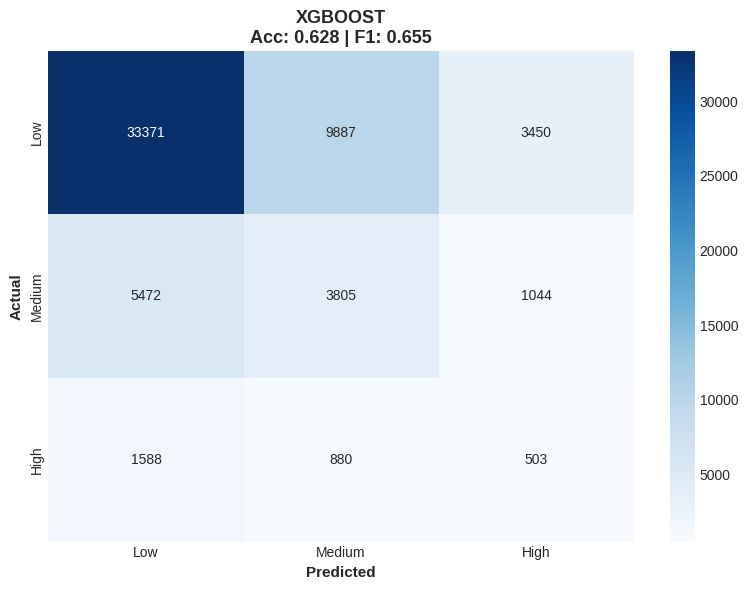

Confusion matrix saved


In [ ]:
# CELL 18: Visualizations
print("\n" + "=" * 70)
print("STEP 14: CREATE VISUALIZATIONS")
print("=" * 70)

model_name = list(results.keys())[0]
cm = results[model_name]['confusion_matrix']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    ax=ax,
    xticklabels=['Low', 'Medium', 'High'],
    yticklabels=['Low', 'Medium', 'High']
)

ax.set_title(
    f'{model_name.upper()}\nAcc: {results[model_name]["accuracy"]:.3f} | F1: {results[model_name]["f1_weighted"]:.3f}',
    fontsize=13, fontweight='bold'
)
ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved")

In [ ]:
# CELL 19: Save Model
print("\n" + "=" * 70)
print("STEP 15: SAVE MODEL")
print("=" * 70)

model_name = list(models.keys())[0]
joblib.dump(models[model_name], 'accident_risk_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

import json
with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f)

print("Model saved:")
print("   - accident_risk_model.pkl")
print("   - scaler.pkl")
print("   - selected_features.json")


STEP 15: SAVE MODELS


KeyError: 'baseline'

In [ ]:
# CELL 20: Final Summary
print("\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

model_name = list(results.keys())[0]
best_f1 = results[model_name]['f1_weighted']

print(f"\nTARGET METRICS:")
print(f"   - Accuracy >= 75%:   {'PASSED' if results[model_name]['accuracy'] >= 0.75 else 'NOT MET'}")
print(f"   - F1-Score >= 0.70:  {'PASSED' if best_f1 >= 0.70 else 'NOT MET'}")

print(f"\nMODEL RESULT:")
print(f"   {model_name.upper()}: F1 = {best_f1:.4f}")

print(f"\nWHAT WE DID:")
print(f"   - Feature Selection (Top {len(selected_features)} features)")
print(f"   - Correlation Analysis")
print(f"   - Data Sampling ({len(df):,} records)")
print(f"   - CONTRIBUTING FACTOR analysis")
print(f"   - SMOTE + Undersampling")
print(f"   - {model_name.upper()} Classifier")

print(f"\nOUTPUT FILES:")
print(f"   - correlation_matrix.png")
print(f"   - feature_importance.png")
print(f"   - confusion_matrix.png")
print(f"   - accident_risk_model.pkl")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)


FINAL SUMMARY

TARGET METRICS:
   - Accuracy >= 75%:   NOT MET
   - F1-Score >= 0.70:  NOT MET

MODEL RESULT:
   XGBOOST: F1 = 0.6551

WHAT WE DID:
   - Feature Selection (Top 10 features)
   - Correlation Analysis
   - Data Sampling (399,999 records)
   - CONTRIBUTING FACTOR analysis
   - SMOTE + Undersampling
   - XGBOOST Classifier

OUTPUT FILES:
   - correlation_matrix.png
   - feature_importance.png
   - confusion_matrix.png
   - accident_risk_model.pkl

ANALYSIS COMPLETE!
